In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="pOcVYS0YKYre27bqF1it")
project = rf.workspace("uidaiproject").project("fingertip-segmentation")
version = project.version(5)
dataset = version.download("coco-segmentation")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fingertip-segmentation-5 in coco-segmentation:: 100%|██████████| 3813/3813 [00:00<00:00, 8004.92it/s]


In [2]:
print(dataset.location)

/content/fingertip-segmentation-5


In [ ]:
from pycocotools.coco import COCO


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import random

In [ ]:
def coco_to_masks(json_path, img_dir, mask_dir):
    os.makedirs(mask_dir, exist_ok=True)
    coco = COCO(json_path)

    for img in coco.imgs.values():
        img_id = img['id']
        img_name = img['file_name']
        h, w = img['height'], img['width']
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        mask = np.zeros((h, w), dtype=np.uint8)
        for ann in anns:
            m = coco.annToMask(ann)
            mask = np.maximum(mask, m * 255)

        mask_img = Image.fromarray(mask)
        mask_img.save(os.path.join(mask_dir, os.path.splitext(img_name)[0] + ".png"))

# Convert masks
base_dir = dataset.location

coco_to_masks(
    os.path.join(base_dir, "train/_annotations.coco.json"),
    os.path.join(base_dir, "train/images"),
    os.path.join(base_dir, "train/masks")
)

coco_to_masks(
    os.path.join(base_dir, "valid/_annotations.coco.json"),
    os.path.join(base_dir, "valid/images"),
    os.path.join(base_dir, "valid/masks")
)

coco_to_masks(
    os.path.join(base_dir, "test/_annotations.coco.json"),
    os.path.join(base_dir, "test/images"),
    os.path.join(base_dir, "test/masks")
)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Image: /content/fingertip-segmentation-5/train/cropped_0_Img_2_3_jpg.rf.eb8cd02999fc27c291bc9653003c0755.jpg
Mask : /content/fingertip-segmentation-5/train/masks/cropped_0_Img_2_3_jpg.rf.eb8cd02999fc27c291bc9653003c0755.png


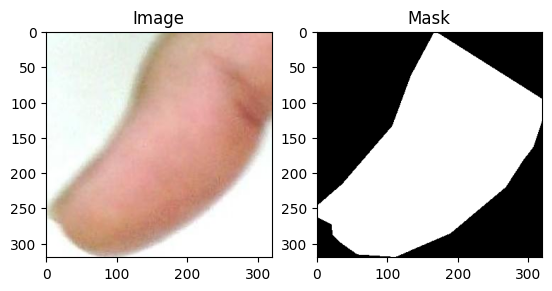

In [ ]:
base_dir = dataset.location
sample_image = os.listdir(os.path.join(base_dir, "train"))[0]

# Skip mask folder itself
while sample_image == "masks" or sample_image.startswith("."):
    sample_image = os.listdir(os.path.join(base_dir, "train"))[1]

image_path = os.path.join(base_dir, "train", sample_image)
mask_path = os.path.join(base_dir, "train/masks", os.path.splitext(sample_image)[0] + ".png")

print("Image:", image_path)
print("Mask :", mask_path)

# Display side by side
import matplotlib.pyplot as plt
img = Image.open(image_path)
mask = Image.open(mask_path)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()


In [ ]:
# U2-NetP Model Architecture (Lightweight)
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate, dilation=1*dirate)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class RSU4F(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F, self).__init__()
        self.rebnconvin = REBNCONV(in_ch, out_ch)
        self.rebnconv1 = REBNCONV(out_ch, mid_ch)
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch)
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch)
        self.rebnconv4 = REBNCONV(mid_ch, mid_ch)

        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch)
        self.rebnconv1d = REBNCONV(mid_ch*2, out_ch)

    def forward(self, x):
        hxin = self.rebnconvin(x)
        h1 = self.rebnconv1(hxin)
        h2 = self.rebnconv2(h1)
        h3 = self.rebnconv3(h2)
        h4 = self.rebnconv4(h3)

        h3d = self.rebnconv3d(torch.cat((h4, h3), dim=1))
        h2d = self.rebnconv2d(torch.cat((h3d, h2), dim=1))
        h1d = self.rebnconv1d(torch.cat((h2d, h1), dim=1))

        return h1d + hxin

class U2NETP(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super(U2NETP, self).__init__()

        self.stage1 = RSU4F(in_ch, 16, 64)
        self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage2 = RSU4F(64, 16, 64)
        self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage3 = RSU4F(64, 16, 64)
        self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage4 = RSU4F(64, 16, 64)
        self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage5 = RSU4F(64, 16, 64)
        self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.stage6 = RSU4F(64, 16, 64)

        self.stage5d = RSU4F(128, 16, 64)
        self.stage4d = RSU4F(128, 16, 64)
        self.stage3d = RSU4F(128, 16, 64)
        self.stage2d = RSU4F(128, 16, 64)
        self.stage1d = RSU4F(128, 16, 64)

        self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side3 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side4 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side5 = nn.Conv2d(64, out_ch, 3, padding=1)
        self.side6 = nn.Conv2d(64, out_ch, 3, padding=1)

        self.outconv = nn.Conv2d(out_ch*6, out_ch, 1)

    def forward(self, x):
        hx1 = self.stage1(x)
        hx = self.pool12(hx1)

        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        hx6 = self.stage6(hx)
        hx6up = nn.functional.interpolate(hx6, size=hx5.shape[2:], mode='bilinear', align_corners=False)

        hx5d = self.stage5d(torch.cat((hx6up, hx5), 1))
        hx5dup = nn.functional.interpolate(hx5d, size=hx4.shape[2:], mode='bilinear', align_corners=False)

        hx4d = self.stage4d(torch.cat((hx5dup, hx4), 1))
        hx4dup = nn.functional.interpolate(hx4d, size=hx3.shape[2:], mode='bilinear', align_corners=False)

        hx3d = self.stage3d(torch.cat((hx4dup, hx3), 1))
        hx3dup = nn.functional.interpolate(hx3d, size=hx2.shape[2:], mode='bilinear', align_corners=False)

        hx2d = self.stage2d(torch.cat((hx3dup, hx2), 1))
        hx2dup = nn.functional.interpolate(hx2d, size=hx1.shape[2:], mode='bilinear', align_corners=False)

        hx1d = self.stage1d(torch.cat((hx2dup, hx1), 1))

        d1 = self.side1(hx1d)
        d2 = nn.Upsample(size=(320, 320), mode='bilinear')(self.side2(hx2d))
        d3 = nn.Upsample(size=(320, 320), mode='bilinear')(self.side3(hx3d))
        d4 = nn.Upsample(size=(320, 320), mode='bilinear')(self.side4(hx4d))
        d5 = nn.Upsample(size=(320, 320), mode='bilinear')(self.side5(hx5d))
        d6 = nn.Upsample(size=(320, 320), mode='bilinear')(self.side6(hx6))

        d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

        return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)


# Custom Dataset
class FingerprintDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)

        # Assuming mask has same name but different extension or in different folder
        mask_name = img_name.replace('.jpg', '.png').replace('.jpeg', '.png')
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Training function
def train_u2net(train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on: {device}")

    model = U2NETP(in_ch=3, out_ch=1).to(device)

    # Multi-scale loss function
    bce_loss = nn.BCELoss(reduction='mean')

    def multi_scale_loss(d0, d1, d2, d3, d4, d5, d6, labels):
        loss0 = bce_loss(d0, labels)
        loss1 = bce_loss(d1, labels)
        loss2 = bce_loss(d2, labels)
        loss3 = bce_loss(d3, labels)
        loss4 = bce_loss(d4, labels)
        loss5 = bce_loss(d5, labels)
        loss6 = bce_loss(d6, labels)

        loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
        return loss

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            d0, d1, d2, d3, d4, d5, d6 = model(data)
            loss = multi_scale_loss(d0, d1, d2, d3, d4, d5, d6, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.6f}')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                d0, d1, d2, d3, d4, d5, d6 = model(data)
                loss = multi_scale_loss(d0, d1, d2, d3, d4, d5, d6, target)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    return model, train_losses, val_losses

In [6]:
# Latency testing function
def test_latency(model, input_size=(1, 3, 320, 320), num_runs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    # Warmup
    dummy_input = torch.randn(input_size).to(device)
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Actual timing
    torch.cuda.synchronize() if torch.cuda.is_available() else None

    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(dummy_input)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_time = time.time()
            times.append(end_time - start_time)

    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    std_time = np.std(times) * 1000

    print(f"Average inference time: {avg_time:.2f} ± {std_time:.2f} ms")
    print(f"FPS: {1000/avg_time:.2f}")

    return avg_time, std_time

Starting U2-Net training for fingerprint segmentation...
Training on: cuda
Epoch: 0, Batch: 0, Loss: 5.240580
Epoch: 0, Batch: 10, Loss: 2.688291
Epoch: 0, Batch: 20, Loss: 3.250868
Epoch: 0, Batch: 30, Loss: 2.093880
Epoch: 0, Batch: 40, Loss: 2.650954
Epoch: 0, Batch: 50, Loss: 2.004637
Epoch: 0, Batch: 60, Loss: 2.422152
Epoch: 0, Batch: 70, Loss: 1.976234
Epoch: 0, Batch: 80, Loss: 2.250419
Epoch: 0, Batch: 90, Loss: 3.175319
Epoch: 0, Batch: 100, Loss: 1.790291
Epoch: 0, Batch: 110, Loss: 2.470070
Epoch: 0, Batch: 120, Loss: 3.857807
Epoch: 0, Batch: 130, Loss: 1.750906
Epoch: 0, Batch: 140, Loss: 1.797247
Epoch: 0, Batch: 150, Loss: 1.680081
Epoch: 0, Batch: 160, Loss: 1.247642
Epoch: 0, Batch: 170, Loss: 2.006636
Epoch: 0, Batch: 180, Loss: 2.576835
Epoch: 0, Batch: 190, Loss: 3.120473
Epoch: 0, Batch: 200, Loss: 1.951301
Epoch: 0, Batch: 210, Loss: 1.534012
Epoch: 0, Batch: 220, Loss: 2.091612
Epoch: 0, Batch: 230, Loss: 1.634995
Epoch: 0, Batch: 240, Loss: 0.971050
Epoch: 0, B

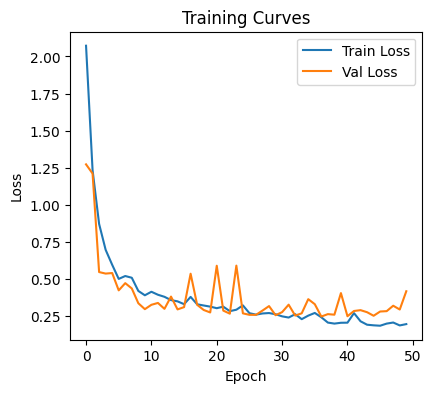

Training completed successfully!


In [ ]:
# Main execution
if __name__ == "__main__":
    # Separate transforms for images and masks
    image_transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor()
    ])

    train_dataset = FingerprintDataset(
        images_dir="/content/fingertip-segmentation-5/train",
        masks_dir="/content/fingertip-segmentation-5/train/masks",
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    val_dataset = FingerprintDataset(
        images_dir="/content/fingertip-segmentation-5/valid",
        masks_dir="/content/fingertip-segmentation-5/valid/masks",
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

    print("Starting U2-Net training for fingerprint segmentation...")
    model, train_losses, val_losses = train_u2net(train_loader, val_loader, num_epochs=50)

    # Save the model
    torch.save(model.state_dict(), 'u2net_fingerprint_model.pth')
    print("Model saved as 'u2net_fingerprint_model.pth'")

    # Test latency
    print("\nTesting model latency...")
    avg_time, std_time = test_latency(model)

    # Plot training curves
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Curves')
    plt.savefig('training_curves.png')
    plt.show()

    print("Training completed successfully!")

# Visualisation and Metrics Calculation

In [ ]:
def visualize_sample(model, dataset, index=0, device='cuda'):
    model.eval()
    image, mask = dataset[index]
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        output = model(input_tensor)[0]
        pred_mask = output.squeeze().cpu().numpy()

    # Show input image, predicted mask, and ground truth mask
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Input Image")
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title("Predicted Mask")
    axs[2].imshow(mask.squeeze(), cmap='gray')
    axs[2].set_title("Ground Truth Mask")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()



In [9]:
def evaluate_iou(model, dataset, device='cuda'):
    model.eval()
    total_iou = 0
    count = 0
    for i in range(len(dataset)):
        image, mask = dataset[i]
        input_tensor = image.unsqueeze(0).to(device)
        target = mask.to(device)

        with torch.no_grad():
            d0, *_ = model(input_tensor)
            pred = d0.squeeze()

        iou = compute_iou(pred, target.squeeze())
        total_iou += iou
        count += 1
    print(f"Avg IoU on Validation Set: {total_iou / count:.4f}")


In [10]:
def compute_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = (target > 0.5).float()

    intersection = (pred * target).sum()
    union = ((pred + target) >= 1).float().sum()
    return (intersection / union).item() if union > 0 else 0


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [13]:
evaluate_iou(model, val_dataset, device=device)


Avg IoU on Validation Set: 0.9344


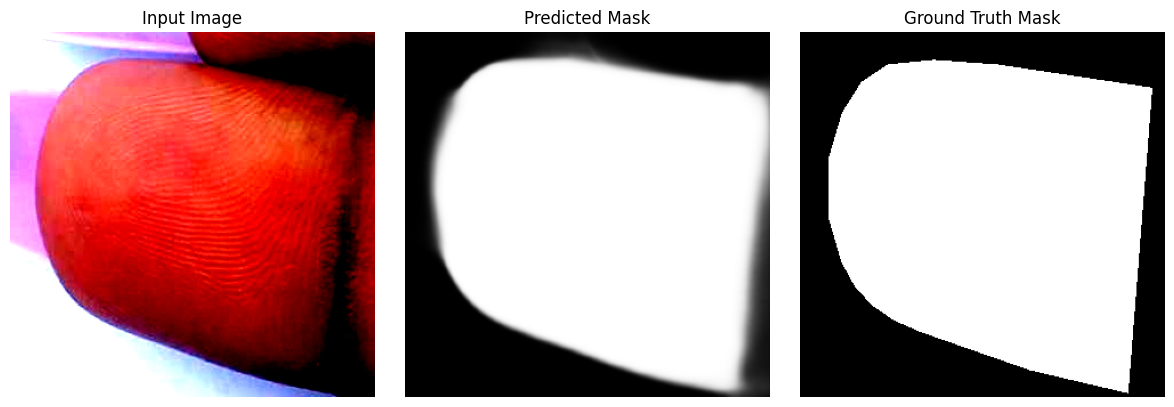

In [14]:
# Move model to evaluation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


visualize_sample(model, val_dataset, device=device, index=0)



In [15]:
# Denormalization utility (for ImageNet-style normalization)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


In [16]:
def segment_fingertip(image_tensor, predicted_mask, threshold=0.5):
    # Denormalize first
    image_tensor = denormalize(image_tensor.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Convert predicted mask to binary
    binary_mask = (predicted_mask > threshold).float()

    # Apply mask
    segmented = image_tensor * binary_mask  # shape [3, H, W]

    # Clamp to [0,1] in case denormalization caused overflow
    return segmented.clamp(0, 1)


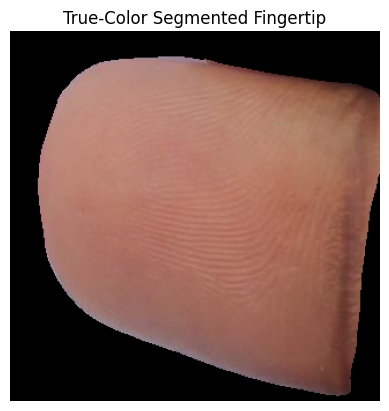

In [17]:
image, _ = val_dataset[0]
image_input = image.unsqueeze(0).to(device)

with torch.no_grad():
    pred_mask, *_ = model(image_input)

segmented = segment_fingertip(image, pred_mask.squeeze().cpu())

plt.imshow(transforms.ToPILImage()(segmented))
plt.title("True-Color Segmented Fingertip")
plt.axis("off")
plt.show()


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torch.nn.functional as F

def compute_segmentation_metrics(preds, targets, threshold=0.5):
    """
    preds, targets: torch.Tensor of shape (H, W)
    threshold: threshold to binarize predictions
    """
    # Flatten
    preds = preds.view(-1).cpu().numpy()
    targets = targets.view(-1).cpu().numpy()

    # Binarize
    preds_bin = (preds > threshold).astype(np.uint8)
    targets_bin = (targets > 0.5).astype(np.uint8)  # Assume target is binary mask

    precision = precision_score(targets_bin, preds_bin, zero_division=0)
    recall = recall_score(targets_bin, preds_bin, zero_division=0)
    f1 = f1_score(targets_bin, preds_bin, zero_division=0)
    accuracy = accuracy_score(targets_bin, preds_bin)
    mae = np.mean(np.abs(preds - targets))

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Accuracy': accuracy,
        'MAE': mae
    }


In [19]:
def evaluate_on_val(model, val_dataset, device):
    model.eval()
    metrics_total = {
        'Precision': 0,
        'Recall': 0,
        'F1 Score': 0,
        'Accuracy': 0,
        'MAE': 0
    }

    with torch.no_grad():
        for i in range(len(val_dataset)):
            image, mask = val_dataset[i]
            image = image.unsqueeze(0).to(device)
            mask = mask.to(device)

            output, *_ = model(image)
            pred = output.squeeze(0).squeeze(0)  # shape: (H, W)
            gt = mask.squeeze(0)  # shape: (H, W)

            metrics = compute_segmentation_metrics(pred, gt)

            for key in metrics_total:
                metrics_total[key] += metrics[key]

    for key in metrics_total:
        metrics_total[key] /= len(val_dataset)

    print("\nValidation Metrics:")
    for key, val in metrics_total.items():
        print(f"{key}: {val:.4f}")


In [20]:
evaluate_on_val(model, val_dataset, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))



Validation Metrics:
Precision: 0.9608
Recall: 0.9693
F1 Score: 0.9633
Accuracy: 0.9825
MAE: 0.0273


In [21]:
test_dataset = FingerprintDataset(
    images_dir="/content/fingertip-segmentation-5/test",
    masks_dir="/content/fingertip-segmentation-5/test/masks",
    image_transform=image_transform,
    mask_transform=mask_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [22]:
def evaluate_model(model, data_loader, device):
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)[0]  # d0 output
            preds = outputs.cpu().numpy() > 0.5
            labels = masks.cpu().numpy() > 0.5

            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"MAE: {mae:.4f}")


In [23]:
evaluate_model(model, test_loader, device=device)


Precision: 0.9662
Recall: 0.9721
F1 Score: 0.9691
Accuracy: 0.9845
MAE: 0.0155


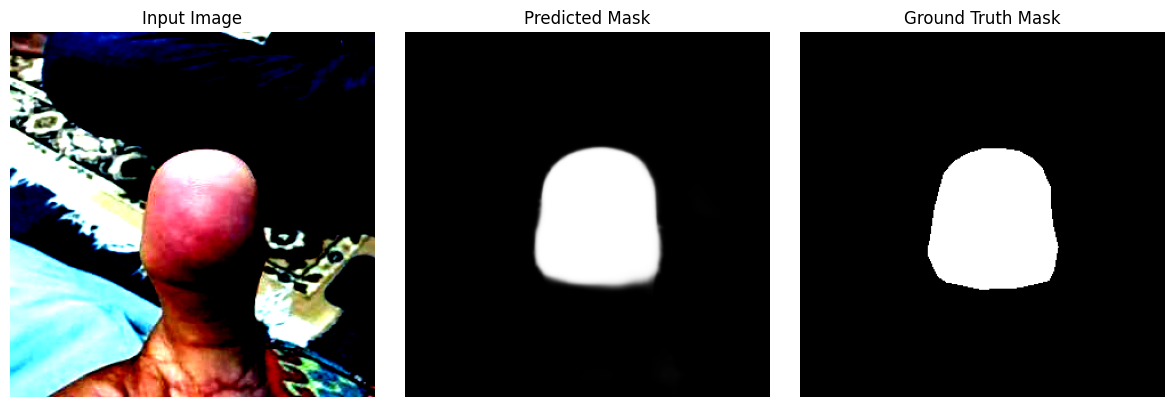

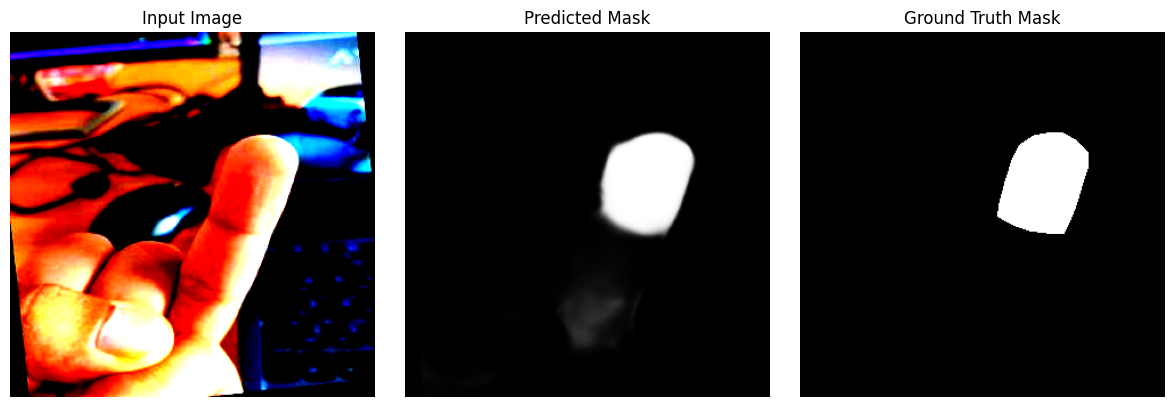

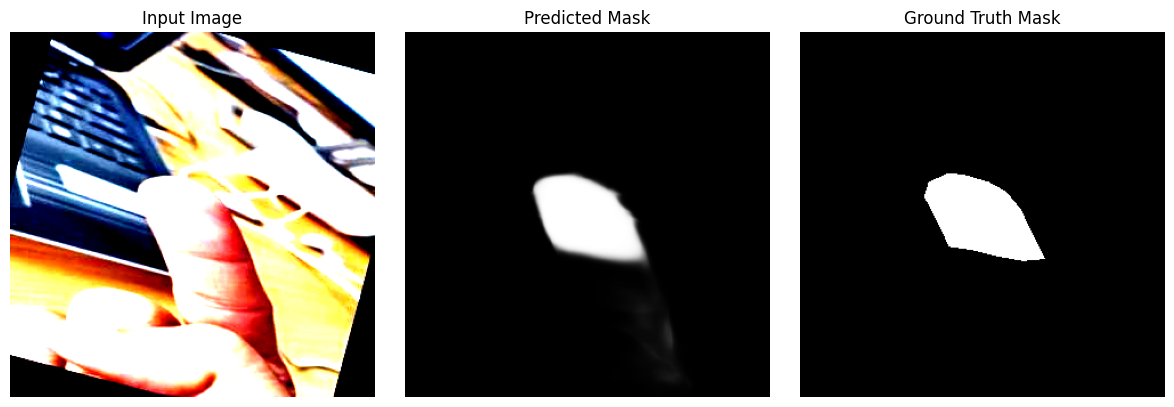

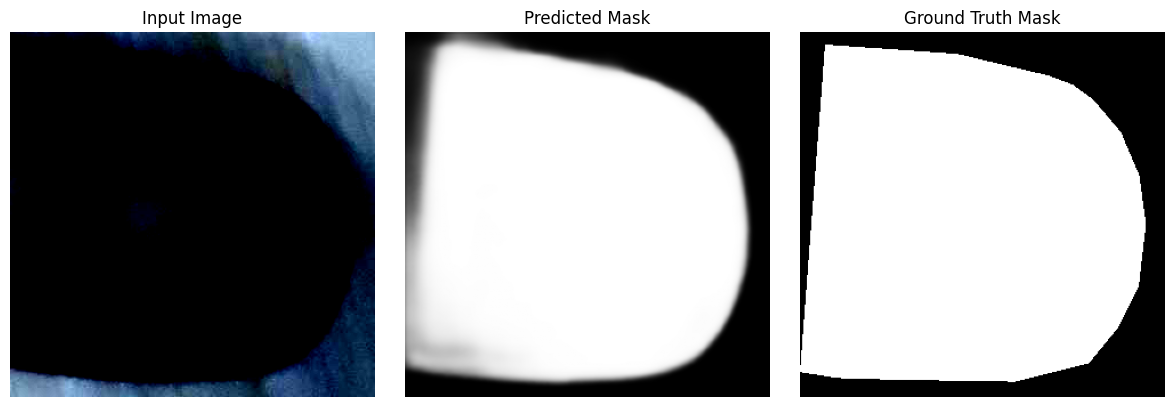

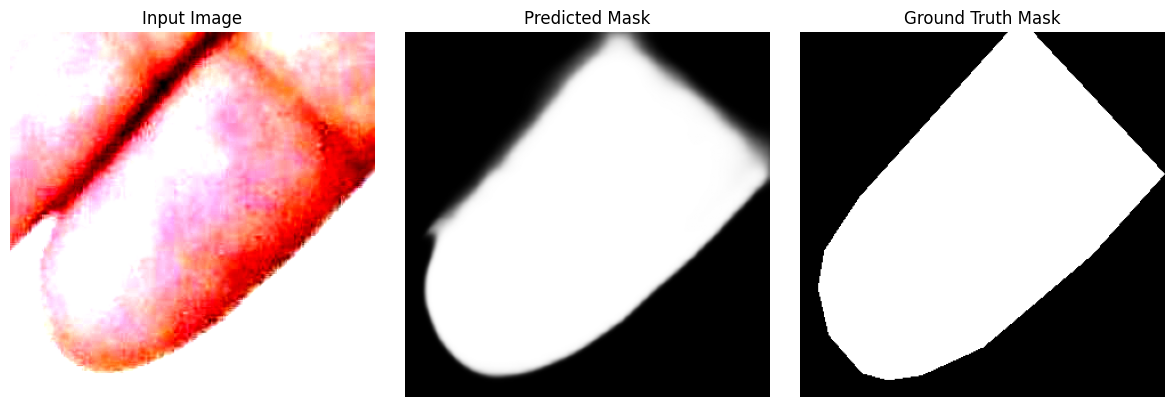

In [ ]:
indices = random.sample(range(len(test_dataset)), 5)
for idx in indices:
    visualize_sample(model, test_dataset, device=device, index=idx)
